In [17]:
# prompt: mount my google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Data manipulation
import numpy as np
import pandas as pd

In [19]:
# Data visualisation
import matplotlib.pyplot as plt

In [20]:
# Fastai
from fastai.vision import *
from fastai.vision.models import *

In [21]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels

In [22]:
from pathlib import Path
import sys

In [23]:
from glob import glob
from PIL import Image

In [24]:
np.random.seed(42)#To make sure that each time you run this kernal, you will get the same beginning parameters.

BATCH_SIZE=64
NUMBER_EPOCHS=25
IMG_SIZE=100

In [25]:
def imshow(img,text=None,should_save=False):#for showing the data you loaded to dataloader
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):# for showing loss value changed with iter
    plt.plot(iteration,loss)
    plt.show()

In [26]:
from collections import defaultdict

#F09xx are used for validation.
val_famillies = "F09"

#An example of data:"../input/train/F00002/MID1/P0001_face1.jpg"
all_images = glob("/content/drive/MyDrive/Data/train/*/*/*.jpg")

train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

train_person_to_images_map = defaultdict(list)#Put the link of each picture under the key word of a person such as "F0002/MID1"
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)
for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
relationships = pd.read_csv("/content/drive/MyDrive/Data/train_relationships.csv")
relationships = list(zip(relationships.p1.values, relationships.p2.values))#For a List like[p1 p2], zip can return a result like [(p1[0],p2[0]),(p1[1],p2[1]),...]
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]#filter unused relationships

train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

print("Total train pairs:", len(train))
print("Total val pairs:", len(val))

Total train pairs: 3066
Total val pairs: 296


In [27]:
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from glob import glob

class TrainingDataset(Dataset):
    def __init__(self, imageFolderDataset, relationships, transform=None, augmentations=None):
        self.imageFolderDataset = imageFolderDataset
        self.relationships = relationships
        self.transform = transform
        self.augmentations = augmentations

    def get_image_path(self, info):
        paths = glob("/content/drive/MyDrive/Data/train/" + info + "/*.jpg")
        return random.choice(paths)

    def get_related_image_path(self, info, cand_relationships):
        img_info = random.choice(cand_relationships)
        img_info = img_info[0] if img_info[0] != info else img_info[1]
        img_path = self.get_image_path(img_info)
        return img_path

    def get_non_related_image_path(self, cand_relationships):
        rand_choose = True
        while rand_choose:
            img_path = random.choice(self.imageFolderDataset.imgs)[0]
            img_info = img_path.split("/")[-3] + "/" + img_path.split("/")[-2]
            rand_choose = any(x[0] == img_info or x[1] == img_info for x in cand_relationships)

        return img_path

    def __getitem__(self, index):
        img0_info = self.relationships[index][0]
        img0_path = self.get_image_path(img0_info)

        cand_relationships = [x for x in self.relationships if x[0] == img0_info or x[1] == img0_info]

        should_get_same_class = random.randint(0, 1)

        if should_get_same_class == 1:
            img1_path = self.get_related_image_path(img0_info, cand_relationships)
        else:
            img1_path = self.get_non_related_image_path(cand_relationships)

        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        if self.augmentations is not None:
            img0 = self.augmentations(img0)
            img1 = self.augmentations(img1)

        return img0, img1, should_get_same_class

    def __len__(self):
        return len(self.relationships)


In [28]:
# Define your data augmentations
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45),  # Rotate the image by a random angle up to 45 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue
    #transforms.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),  # Randomly crop and resize the image
    #transforms.RandomGrayscale(p=0.1),  # Randomly convert the image to grayscale
    transforms.RandomRotation(degrees=30),
    transforms.RandomRotation(degrees=60),
    # Add more augmentations as needed
    # Add more augmentations as needed
])


In [29]:
folder_dataset = dset.ImageFolder(root='/content/drive/MyDrive/Data/train')

# Use augmentations in your TrainingDataset
trainset = TrainingDataset(
    imageFolderDataset=folder_dataset,
    relationships=train,
    transform=transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ]),
    augmentations=augmentations
)

trainloader = DataLoader(
    trainset,
    shuffle=True,
    num_workers=2,
    batch_size=BATCH_SIZE
)

valset = TrainingDataset(
    imageFolderDataset=folder_dataset,
    relationships=val,
    transform=transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])
)

valloader = DataLoader(
    valset,
    shuffle=True,
    num_workers=2,
    batch_size=BATCH_SIZE
)


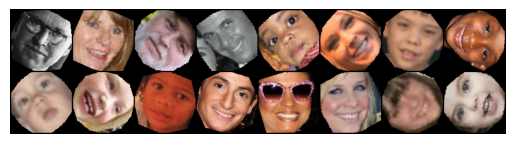

[1 1 0 1 1 0 0 0]


In [30]:
#only for visualize data in dataloader, it won't matters if you delete this block.
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            #nn.Dropout2d(p=0.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            #nn.Dropout2d(p=0.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            #nn.Dropout2d(p=0.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            #nn.Dropout2d(p=0.3),

            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(p=0.3),


        )

        num_features = self.calculate_conv_output_size()

        self.fc1 = nn.Linear(2 * num_features, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2)

    def calculate_conv_output_size(self):
        x = torch.randn(1, 3, 100, 100)
        x = self.cnn1(x)
        return x.view(x.size(0), -1).size(1)

    def forward_one_branch(self, x):
        x = self.cnn1(x)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, img0, img1):
        output0 = self.forward_one_branch(img0)
        output1 = self.forward_one_branch(img1)

        concatenated = torch.cat((output0, output1), 1)

        x = F.relu(self.fc1(concatenated))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Epoch: 0 start.
Epoch: 0, Loss: 0.6982, Accuracy: 0.51%, Precision: 0.5103, Recall: 0.5103, F1 Score: 0.5103
Epoch: 1 start.
Epoch: 1, Loss: 0.6650, Accuracy: 0.58%, Precision: 0.5730, Recall: 0.5675, F1 Score: 0.5637
Epoch: 2 start.
Epoch: 2, Loss: 0.6709, Accuracy: 0.69%, Precision: 0.6925, Recall: 0.6926, F1 Score: 0.6925
Desired accuracy of 65.00% reached. Stopping training.


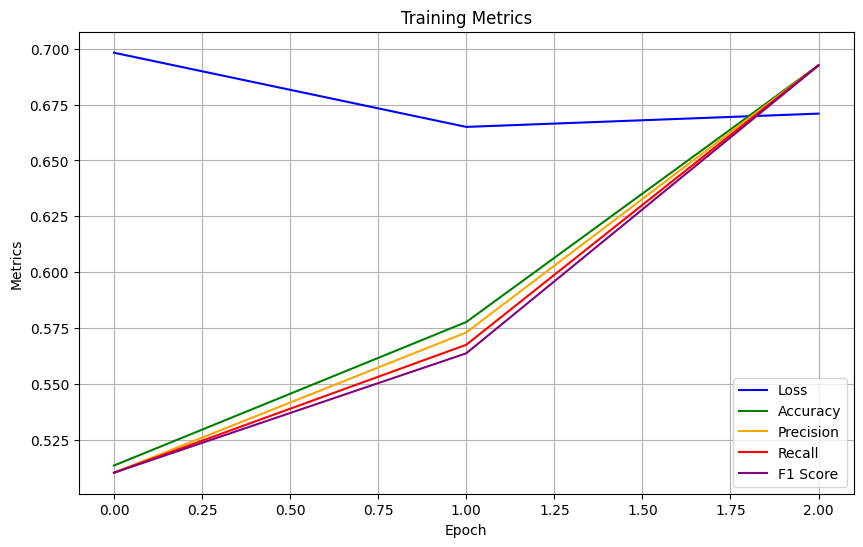

In [34]:
net = SiameseNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score



# Set the desired accuracy threshold
desired_accuracy = 0.65


# Define learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust based on your preference

# Lists to store metrics
epoch_numbers = []
accuracy_list = []
loss_list = []
precision_list = []
recall_list = []
f1_list = []

for epoch in range(NUMBER_EPOCHS):
    print("Epoch:", epoch, "start.")

    net.train()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    predicted_labels = []
    true_labels = []

    for i, data in enumerate(trainloader, 0):
        img0, img1, labels = data
        img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = net(img0, img1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate validation metrics
    net.eval()
    with torch.no_grad():
        for data in valloader:
            img0, img1, labels = data
            img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()

            outputs = net(img0, img1)
            _, predicted = torch.max(outputs.data, 1)

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(trainloader)
        accuracy = correct_val / total_val
        precision = precision_score(true_labels, predicted_labels, average='macro')
        recall = recall_score(true_labels, predicted_labels, average='macro')
        f1 = f1_score(true_labels, predicted_labels, average='macro')

        epoch_numbers.append(epoch)
        accuracy_list.append(accuracy)
        loss_list.append(epoch_loss)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}'.format(
            epoch, epoch_loss, accuracy, precision, recall, f1))


        if accuracy >= desired_accuracy:
            print(f"Desired accuracy of {desired_accuracy*100:.2f}% reached. Stopping training.")
            break

    # Step the learning rate scheduler
    scheduler.step()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(epoch_numbers, loss_list, label='Loss', color='blue')
plt.plot(epoch_numbers, accuracy_list, label='Accuracy', color='green')
plt.plot(epoch_numbers, precision_list, label='Precision', color='orange')
plt.plot(epoch_numbers, recall_list, label='Recall', color='red')
plt.plot(epoch_numbers, f1_list, label='F1 Score', color='purple')

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
save_path = '/content/drive/MyDrive/sgd-aug-50-69acc.pth'
torch.save(net.state_dict(), save_path)


In [36]:
save_path = '/content/drive/MyDrive/sgd-aug-50-69_full.pth'
torch.save(net, save_path)

In [17]:
save_path = '/content/drive/MyDrive/sgd-aug-50.pth'
torch.save(net.state_dict(), save_path)


In [18]:
save_path = '/content/drive/MyDrive/sgd-aug-50_full.pth'
torch.save(net, save_path)

In [ ]:
save_path = '/content/drive/MyDrive/sgd-aug2.pth'
torch.save(net.state_dict(), save_path)


In [ ]:
save_path = '/content/drive/MyDrive/sgd-aug_full.pth'
torch.save(net, save_path)

In [ ]:
save_path = '/content/drive/MyDrive/sgd-aug.pth'
torch.save(net.state_dict(), save_path)


In [ ]:
save_path = '/content/drive/MyDrive/sgd-aug_full.pth'
torch.save(net, save_path)

In [ ]:
save_path = '/content/drive/MyDrive/adam-aug.pth'
torch.save(net.state_dict(), save_path)


In [ ]:
save_path = '/content/drive/MyDrive/adam-aug_full.pth'
torch.save(net, save_path)


In [37]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv

    def __init__(self,transform=None):
        self.test_df = pd.read_csv('/content/drive/MyDrive/Data/sample_submission.csv')#pandas用来读取csv文件
        self.transform = transform

    def __getitem__(self,index):
        #data in submission.csv:
        #       img_pair               is_related
        #face05508.jpg-face01210.jpg       0
        #face05820.jpg-face03938.jpg       0

        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]
        #print(img0_path,'-',img1_path) #reserved to check whether test data is in order.

        img0 = Image.open('/content/drive/MyDrive/Data/test/'+img0_path)
        img1 = Image.open('/content/drive/MyDrive/Data/test/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1

    def __len__(self):
        return len(self.test_df)

In [38]:
testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be out of order
#if you have better method, please tell me! thanks a lot!

In [48]:
test_df = pd.read_csv('/content/drive/MyDrive/Data/sample_submission.csv')#pandas用来读取csv文件
predictions=[]
with torch.no_grad():
    for data in testloader:
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)#taking care of here, the output data format is important for transfer

test_df['is_related'] = predictions
test_df.to_csv("submission.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.0
1,face05750.jpg-face00898.jpg,1.0
2,face05820.jpg-face03938.jpg,0.0
3,face02104.jpg-face01172.jpg,1.0
4,face02428.jpg-face05611.jpg,0.0
5,face01219.jpg-face00274.jpg,0.0
6,face04262.jpg-face00555.jpg,1.0
7,face03697.jpg-face01892.jpg,0.0
8,face03524.jpg-face00319.jpg,1.0
9,face03410.jpg-face05368.jpg,1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# Import necessary libraries
from PIL import Image
from torchvision.transforms import transforms
import torch

# Define the path to the saved model
saved_model_path = '/content/drive/MyDrive/sgd21.pth'
#RUN SIAMESE NETWORK CLASS AGAIN!!!!!
# Create an instance of the Siamese Network
net = SiameseNetwork().cuda()

# Load the saved model state dictionary
net.load_state_dict(torch.load(saved_model_path))
net.eval()  # Set the model to evaluation mode

# ... (rest of the code for making predictions on new data)


In [39]:
# Define a function to preprocess images
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])
    img = transform(img)
    return img.unsqueeze(0)  # Add a batch dimension
    #RUN IMG_SIZE BLOCK AGAIN !!!!!!

In [40]:
def pred_rel(img_path1,img_path2):
      image_path1 = img_path1
      image_path2 = img_path2

      # Preprocess the images
      img1 = preprocess_image(image_path1).cuda()
      img2 = preprocess_image(image_path2).cuda()

      # Make the prediction
      with torch.no_grad():
          output = net(img1, img2)
          _, predicted_label = torch.max(output.data, 1)

      # Check the predicted label (1 for related, 0 for non-related)
      if predicted_label.item() == 1:
          print("The two people are related.")
      else:
          print("The two people are not related.")


In [47]:
pred_rel('/content/nisha.jpeg','/content/nisha2.jpeg')

The two people are related.
